In [1]:
import sys

sys.path.insert(0, "../..")
import sys
import os

In [4]:
ls ../..

caldera/         examples/  poetry.lock     README.md         tmp/
docsrc/          LICENSE    pyproject.toml  requirements.txt
environment.yml  Makefile   pytest.ini      tests/


{'edge': {'keys': {'_target': {<class 'numpy.ndarray'>},
                   'shortest_path': {<class 'bool'>}}},
 'global': {'keys': {}},
 'node': {'keys': {'_features': {<class 'numpy.ndarray'>},
                   '_target': {<class 'numpy.ndarray'>},
                   'shortest_path': {<class 'bool'>},
                   'source': {<class 'bool'>},
                   'target': {<class 'bool'>}}}}


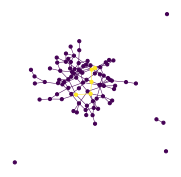

In [90]:
from caldera.testing import annotate_shortest_path, random_graph, feature_info, random_node, _resolve_range
from caldera.utils.nx.convert import add_default, nx_collect_features, flatten_edges, flatten_global, flatten_nodes
from pprint import pprint
import networkx as nx
import uuid
import itertools
import pylab as plt


%matplotlib inline

def unode():
    return str(uuid.uuid4())[-5:]

def line_path(nodes):
    g = nx.DiGraph()
    for n1, n2 in nx.utils.pairwise(nodes):
        g.add_edge(n1, n2)
    return g

def compose_and_connect(g, h, density):
    """Compose graphs and add edges to compute the density"""
    i = nx.compose(g, h)
    
    existing_edges = 0
    possible_edges = g.size() * h.size()
    for n1, n2 in i.edges():
        if (n1 in g and n2 in h) or (n2 in g and n1 in h):
            existing_edges += 1
            
    num_new_edges = int(possible_edges * density - existing_edges)
    for _ in range(num_new_edges):
        n1 = random_node(g)
        n2 = random_node(h)
        i.add_edge(n1, n2)
    return i

def annotate_shortest_path(
    g: nx.Graph,
    annotate_nodes: bool = True,
    annotate_edges: bool = True,
    source_key: str = "source",
    target_key: str = "target",
    path_key: str = "shortest_path",
    source: str = None,
    target: str = None
) -> nx.Graph:
    """
    
    :param g: 
    :param annotate_nodes: 
    :param annotate_edges: 
    :param source_key: 
    :param target_key: 
    :param path_key: 
    :param source: 
    :param target: 
    :return: 
    """
    if not annotate_edges and not annotate_nodes:
        raise ValueError("Must annotate either nodes or edges (or both)")
    source = source or random_node(g)
    target = target or random_node(g)

    g.nodes[source][source_key] = True
    g.nodes[target][target_key] = True

    try:
        path = nx.shortest_path(g, source=source, target=target)
    except nx.NetworkXNoPath:
        path = []

    add_default(g, node_data={target_key: False, source_key: False, path_key: False})
    add_default(g, edge_data={path_key: False})

    if annotate_nodes:
        for n in path:
            g.nodes[n][path_key] = True

    if annotate_edges:
        for n1, n2 in nx.utils.pairwise(path):
            g.edges[(n1, n2)][path_key] = True


def generate_shorest_path_example(n_nodes, density, path_length):
    d = _resolve_range(density)
    l = _resolve_range(path_length)
    _path = [unode() for _ in range(l)]
    _g = random_graph(n_nodes, density=d)
    _h = line_path(_path)
    g = compose_and_connect(_g, _h, d)


    annotate_shortest_path(g, 
                           True, True, 
                           source_key='source', 
                           target_key='target', 
                           path_key='shortest_path', 
                           source=_path[0], 
                           target=_path[-1]
                          )

    add_default(g, node_data={'source': False, 'target': False, 'shortest_path': False})
    add_default(g, edge_data={'shortest_path': False})
    nx_collect_features(g, 'node', 'source', '_features', encoding='onehot', classes=[False, True])
    nx_collect_features(g, 'node', 'target', '_features', encoding='onehot', classes=[False, True])
    nx_collect_features(g, 'node', 'shortest_path', '_target', encoding='onehot', classes=[False, True])
    nx_collect_features(g, 'edge', 'shortest_path', '_target', encoding='onehot', classes=[False, True])
    return g

def draw_shortest_path(g):
    pprint(feature_info(g))
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')
    nodelist = list(g.nodes)

    node_color = []
    for n in nodelist:
        node_color.append(g.nodes[n]['shortest_path'])

    edge_list = []
    edge_color = []
    for n1, n2, edata in g.edges(data=True):
        edge_list.append((n1, n2))
        edge_color.append(edata['shortest_path'])

    pos = nx.layout.spring_layout(g)
    nx.draw_networkx_nodes(g, pos=pos, node_color=node_color, node_size=10, ax=ax)
    nx.draw_networkx_edges(g, pos=pos, width=0.5, edge_color=edge_color, ax=ax)
    

g = generate_shorest_path_example((30, 100), (0.01, 0.03), (3, 15))
draw_shortest_path(g)

In [97]:
## Generate Examples

In [101]:
from tqdm.auto import tqdm

In [109]:
generate_example = lambda: generate_shorest_path_example((30, 100), (0.01, 0.03), (3, 15))

num_examples = 100

examples = [generate_example() for _ in tqdm(range(num_examples))]

In [116]:
from caldera.utils.nx import nx_to_directed

def nx_copy(g1: nx.Graph, g2: nx.Graph = None, deepcopy: bool = False, node_transform = None) -> nx.Graph:
    if g2 is None:
        g2 = g1.__class__()
    for n, ndata in g1.nodes(data=True):
        if deepcopy:
            n, ndata = do_deepcopy((n, ndata))
            
        if node_transform:
            n = node_transform(n)
        g2.add_node(n, **ndata)
    for n1, n2, edata in g1.edges(data=True):
        if node_transform:
            n1 = node_transform(n1)
            n2 = node_transform(n2)
        if deepcopy:
            n1, n2, edata = do_deepcopy((n1, n2, edata))
        g2.add_edge(n1, n2, **edata)
    return g2

examples = [nx_to_directed(g) for g in examples]
examples = [nx_copy(g, node_transform=lambda x: str(x)) for g in examples]



In [119]:
from caldera.data import GraphDataLoader, GraphDataset
from caldera.data import GraphData, GraphBatch


print(feature_info(examples[-1]))
datalist = [GraphData.from_networkx(g, feature_key='_features') for g in examples]

{'node': {'keys': {'target': {<class 'bool'>}, 'source': {<class 'bool'>}, 'shortest_path': {<class 'bool'>}, '_features': {<class 'numpy.ndarray'>}, '_target': {<class 'numpy.ndarray'>}}}, 'edge': {'keys': {'shortest_path': {<class 'bool'>}, '_target': {<class 'numpy.ndarray'>}}}, 'global': {'keys': {}}}


KeyError: '_features'

In [108]:
examples